# Compute the pKa's from a replica-exchange simulation

Here we show some basic operations for analyzing the results of a pH replica-exchange simulation in Amber. In pH replica exchange several copies of the system are simulated at different pH values simultaneously, and these replicas periodically attempt to swap pH values. This movement in pH space can help simulations avoid getting trapped in local free energy minima.

The basic process is similar to the analysis of single-pH simulations, but in Amber each lambda file obtained from a pH replica-exchange simulation contain frames from all of the pH conditions, and if we are to analyze the data we need to separate this information by pH.

## Import library

First, import the analysis tools and plotting libraries

In [5]:
from cphmd_tools import cphmdanalysis
import matplotlib
import matplotlib.pyplot as plt

## Define constants

Here, I define the pH values used in the replica-exchange simulation. I define them as strings as well to make it easier for me to open the files later.

Here we used a spacing of 0.5 pH units between replicas, but this may change in other systems. Generally, one wants to use as few replicas as possible while still covering the pH range of interest. However, if replicas are placed too far apart in pH space they will not swap frequently, and the efficiency of the method will suffer. In general, we have found a spacing of 0.5 units in pH space to be a reasonable first attempt, but for difficult systems a finer spacing of replicas will be required.

Looking at how the replicas move through pH space is one way to check for issues with too widely spaced replicas, and you can see how to do that below.

In [1]:
rex_ph_strings = ['3.0', '3.5', '4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5']
rex_phs = [float(ph) for ph in rex_ph_strings]

## Read lambda files

The first step is to read in all of the lambda files generated from the simulations. In example_data/rex_lambdas we have the lambda files generated from a set of replica exchange simulations. This command creates a list of lambda_file objects, which each store all of the information from the lambda files so it can easily be accessed through the members of the objects. These objects are then used by the other functions to calculate the pKa's.

For a detailed definition of the lambda_file objects and a list of all members, check the detailed documentation in cphmdanalysis.py.

In [3]:
replica_lambda_files = [cphmdanalysis.lambda_file('example_data/rex_lambdas/1eh6{}.lambda'.format(ph))
                        for ph in rex_ph_strings]

## Read in replica log file

Amber outputs a log file displaying how the replicas move through pH space with time. Reading this information is required so that we can separate the lambda files by pH. This command produces a rem_file object that contains the information in the log file. This information can be used to verify that the replica-exchange simulation ran reasonably and to separate the lambda values by pH. Both these options are shown below.

The constructor takes two arguments, the path to the log file and the swap frequency in the replica-exchange simulations. This value must be given because there is no requirement that the swap frequency and the frequency with which the lambda files are printed are the same. The swap frequency is not in the log file or the lambda file and so must be provided here.

In [6]:
swap_rate = 1000
rem_file = cphmdanalysis.rem_file('example_data/rex_lambdas/1eh6_rem.log', swap_rate)

## Examine replica movement through pH space

As mentioned above, when running replica-exchange simulations, it is important to verify that the replicas are moving efficiently through pH space. If there are bottlenecks, new replicas will need to be added in those regions. Here we plot the progress of the replicas through pH space to verify that everything is fine.

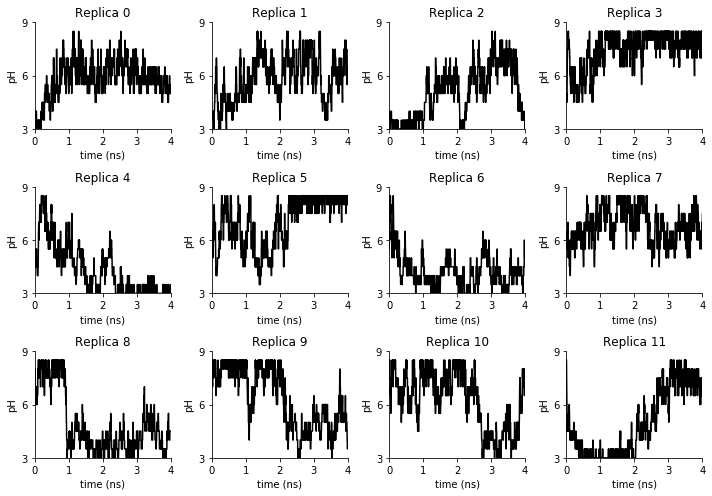

In [10]:
plt.close('all')
figrows = 3
figcols = 4
width = 10
height = 7
time_step = 0.000002
xlims = [0, 4]
xticks = [0, 1, 2, 3, 4]
ylims = [3, 9]
yticks = [3, 6, 9]
xlabel = 'time (ns)'
ylabel = 'pH'

fig, axes = plt.subplots(ncols = figcols, nrows = figrows, figsize = (width, height))
flat_axes = axes.flatten()
for i, axis in enumerate(flat_axes):
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_xlim(xlims)
    axis.set_xticks(xticks)
    axis.set_ylim(ylims)
    axis.set_yticks(yticks)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title('Replica {}'.format(i))
    #Gather the pH as a function of time for replica i
    y_values = [ph_vec[i] for ph_vec in rem_file.phs]
    #Compute times for each swap
    x_values = [j * time_step * swap_rate for j in range(len(rem_file.phs))]
    axis.plot(x_values, y_values, 'k-')
fig.tight_layout()
plt.show()

These look ok. All of the replicas are moving pretty well through pH space.

## Wrap lambda files

To compute the pKa's from replica exchange simulations, we have to separate the lambda values by pH. Here is where we do that. the wrap_lambda_files function takes a rem_file object, a list of lambda_file objects, and a list of pHs and returns a new set of lambda files that are separated properly by pH.

One note, the wrap_lambda_files function runs compute_s_values on the lambda files, so there is no need to run that function if you are wrapping the data.

In [11]:
wrapped_lambda_files = cphmdanalysis.wrap_lambda_files(rem_file, replica_lambda_files, rex_phs)

## Compute pKa's

Now, compute the pKa's of the titratable residues. compute_pkas returns a list of lists containing one list for each titratable residue that in turn contains in order the Hill coefficient, the fitting error in the Hill coefficient, the pKa, and the fitting error in pKa.

Because the Henderson-Hasselbalch equation is nonlinear, we have to make initial guesses for the Hill coefficient and pKa. The algorithm here guesses that the Hill coefficient is 1. It takes as the initial guess of the pKa the pH value the unprotonated fraction is closest to 0.5, unless none of the unprotonated fractions are between 0.1 and 0.9. If there is no appropriate pH to pick as an initial guess or if the fitting function fails to converge, the algorithm will return math.nan for the pKa data for that residue.

This function does not throw errors when the fitting fails because often there will be residues that do not titrate in the pH range, and if these residues are not ones you are interested in it is usually not a problem. Later in the notebook, I will show how to look more closely at these cases.

In [12]:
pka_data = cphmdanalysis.compute_pkas(rex_phs, wrapped_lambda_files)

## Print pKa data

Now, print the pKa estimates and Hill values. Note that the titrreses directory in the lambda_file objects contains the residue indices of the titratable residues. This means, if, for example, we want to know what the pKa of a particular residue is, we can pull it out of the pKa data using this array, as is shown in the next cell.

In [18]:
print('Residue Hill pKa')
for i, resid in enumerate(wrapped_lambda_files[0].titrreses):
    print('{} {:.2f} {:.1f}'.format(resid, pka_data[i][0], pka_data[i][2]))

Residue Hill pKa
2 0.74 8.3
3 0.90 3.7
5 nan nan
10 0.74 3.4
15 nan nan
17 0.73 4.3
21 0.33 6.0
22 0.64 3.8
26 0.47 7.0
27 0.71 3.3
29 nan nan
33 nan nan
39 0.80 3.5
42 0.84 4.2
54 0.76 3.9
59 nan nan
68 0.93 7.6
71 0.75 4.0
74 0.71 4.5
75 0.71 4.6
82 0.55 6.8
83 nan nan
89 0.88 3.7
98 nan nan
101 nan nan
104 nan nan
107 0.79 3.8
122 nan nan
142 0.55 6.7
143 nan nan
147 0.28 1.7
162 nan nan
163 0.83 4.2
168 0.85 7.4
169 0.83 3.2
171 0.84 6.5


Say that we are interested specifically in the pKa of residue 142, which was the Cys residue we were intersted in. We can use the titrreses array in the lambda_file object to pull it out of the pka_data object:

In [13]:
residue = 142
print('pKa of residue 142 = {:.1f}'.format(pka_data[wrapped_lambda_files[0].titrreses.index(residue)][2]))

pKa of residue 142 = 6.7


We can check to see why a residue did not return a pKa by looking directly at the unprotonated fractions:

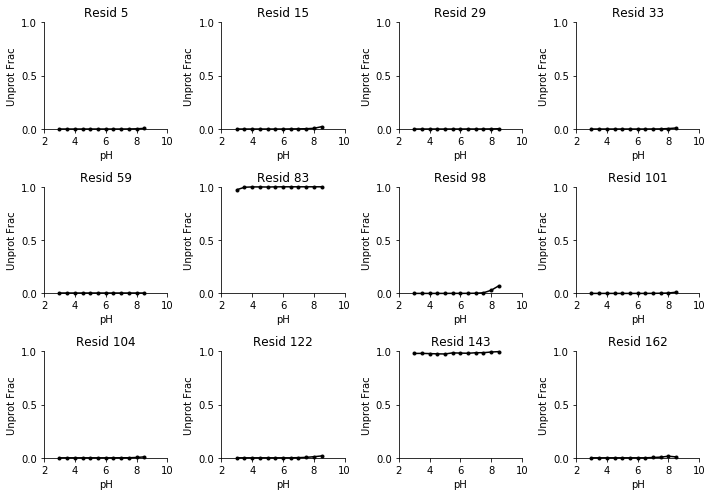

In [16]:
plt.close('all')
figrows = 3
figcols = 4
width = 10
height = 7
ylims = [0, 1]
yticks = [0, 0.5, 1]
xlims = [2, 10]
xticks = [2, 4, 6, 8, 10]
xlabel = 'pH'
ylabel = 'Unprot Frac'

#List residues that have pKa=nan
nan_residue_list = [5, 15, 29, 33, 59, 83, 98, 101, 104, 122, 143, 162]

fig, axes = plt.subplots(ncols = figcols, nrows = figrows, figsize = (width, height))
flat_axes = axes.flatten()
for i, axis in enumerate(flat_axes):
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_ylim(ylims)
    axis.set_yticks(yticks)
    axis.set_xlim(xlims)
    axis.set_xticks(xticks)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title('Resid {}'.format(nan_residue_list[i]))
    #Get S-values (unprotonated fractions) for residue i
    s_values = [lambda_file.s[lambda_file.titrreses.index(nan_residue_list[i])]
               for lambda_file in wrapped_lambda_files]
    axis.plot(rex_phs, s_values, 'k-', marker = '.', clip_on = False)
fig.tight_layout()
plt.show()

Apparently, residues 5, 15, 29, 33, 59, 98,101, 104, 122, and 162 have pKa's above our pH range (>8.5). Conversely, residues 83 and 143 appear to have a pKa below our pH range (<3)